# Transfer Learning
* Augmentation Layer
* Comparing between multiples model

In [ ]:
# Download the data and function to help
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir
unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"


--2022-06-14 14:28:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 173.194.202.128, 173.194.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   270MB/s    in 0.6s    

2022-06-14 14:28:38 (270 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]

--2022-06-14 14:28:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request s

## Preparing the train and test dataset

In [ ]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode='categorical',
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=BATCH_SIZE)
validate_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                    label_mode='categorical',
                                                                    image_size=IMG_SIZE,
                                                                    batch_size=BATCH_SIZE
                                                                    )

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Crreate layer for augmentation

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras

data_augmentation = keras.Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255.) some model need to use rescaling
], name='data_augmentation')

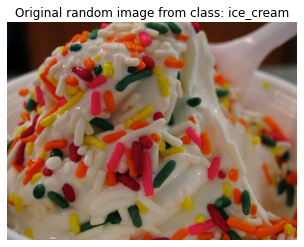

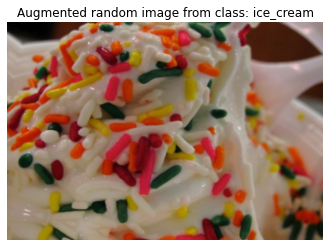

In [ ]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_10_percent.class_names) # choose a random class
target_dir = "10_food_classes_10_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path

# Plot the random image (original)
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(img, training=True)
plt.figure()
plt.imshow(augmented_img/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

# Create and compare model


## Model_0

Create base model by using [EfficientNetB0](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0) as a base mdel

In [ ]:
# Create base model or backbone

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs
inputs = layers.Input(shape=(224,224,3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
# Change into feature vector
x = layers.GlobalAveragePooling2D(name='global_average_pooling_2d')(x)
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)
model_0 = tf.keras.Model(inputs,outputs)

model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
# Summary the model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2d (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainabl

### ModelCheckpoint Callbacks
To save the progress in each epoch

In [ ]:
checkpoint_path = 'ten_percent_model_checkpoints_weights/checkpoint.ckpt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq='epoch',
                                                         verbose = 1) # save very epoch

In [ ]:
# Fit the model saving checkpoints every epochs
initial_epochs = 5
history_0 =  model_0.fit(train_data_10_percent,
                         epochs=initial_epochs,
                         validation_data=validate_data,
                         validation_steps=int(0.25*len(validate_data)),
                         callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                experiment_name='10_percent_data_aug'),
                                    checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220614-142851
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0824 - accuracy: 0.2747WARNING:tensorflow:Model was constructed with shape (384, 512, 3) for input KerasTensor(type_spec=TensorSpec(shape=(384, 512, 3), dtype=tf.uint8, name='random_flip_input'), name='random_flip_input', description="created by layer 'random_flip_input'"), but it was called on an input with incompatible shape (None, 224, 224, 3).

Epoch 1: val_loss improved from inf to 1.57073, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 31s 576ms/step - loss: 2.0824 - accuracy: 0.2747 - val_loss: 1.5707 - val_accuracy: 0.5921
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4006 - accuracy: 0.6427
Epoch 2: val_loss improved from 1.57073 to 1.12732, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [=====================

In [ ]:
evaluate_0 = model_0.evaluate(validate_data)

79/79 [==============================] - 7s 78ms/step - loss: 0.7111 - accuracy: 0.8108


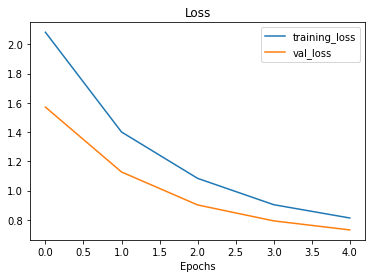

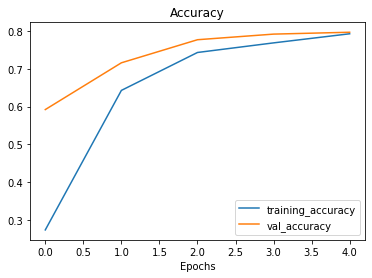

In [ ]:
plot_loss_curves(history_0)

## Model #1

In [ ]:
# Global Parameters
input_shape=(224,224,3)

# Create base model or backbone
base_model_1 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model_1.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name='input_layer')

# Add in data augmentaion layer
x = data_augmentation(inputs)

# Give base_model_1 an inputs (after augmentation) and don't train it
x = base_model_1(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D()(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation='softmax',name='output_layer')(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# Fit the model
history_1 = model_1.fit(train_data_10_percent,
            epochs=initial_epochs,
            callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                      experiment_name='10_percent_data_aug'),
                      checkpoint_callback],
            validation_data=validate_data,
            validation_steps=int(0.25*len(validate_data)))

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220614-143027
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0706 - accuracy: 0.2947WARNING:tensorflow:Model was constructed with shape (384, 512, 3) for input KerasTensor(type_spec=TensorSpec(shape=(384, 512, 3), dtype=tf.uint8, name='random_flip_input'), name='random_flip_input', description="created by layer 'random_flip_input'"), but it was called on an input with incompatible shape (None, 224, 224, 3).

Epoch 1: val_loss did not improve from 0.73121
24/24 [==============================] - 15s 369ms/step - loss: 2.0706 - accuracy: 0.2947 - val_loss: 1.5698 - val_accuracy: 0.6151
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3773 - accuracy: 0.6827
Epoch 2: val_loss did not improve from 0.73121
24/24 [==============================] - 9s 347ms/step - loss: 1.3773 - accuracy: 0.6827 - val_loss: 1.1008 - val_accuracy: 0.7467
Epoch 3/5
24/24 [==========================

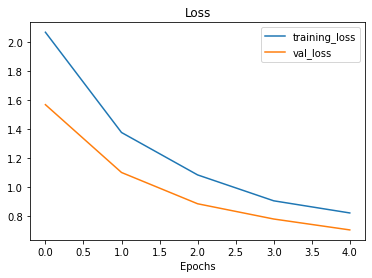

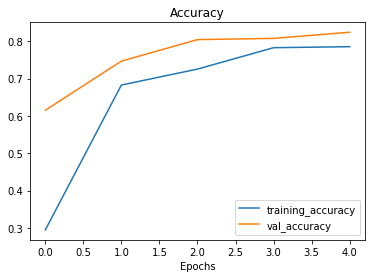

In [ ]:
plot_loss_curves(history_1)

In [ ]:
evaluate_1 = model_1.evaluate(validate_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.7048 - accuracy: 0.8156


### Loading in checkpointed weights

In [ ]:
model_1.load_weights(checkpoint_path)

# Evaluated model_2 with loaded weights
loaded_weights_model_results = model_1.evaluate(validate_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.7048 - accuracy: 0.8156


In [ ]:
evaluate_1 == loaded_weights_model_results

True

In [ ]:
loaded_weights_model_results

[0.7047861218452454, 0.8155999779701233]

## Model_2: Fine tuning from Model_1

Fine tune of the model#1

In [ ]:
# Layers in model#1

model_1.layers

In [ ]:
# Check the layers are trainable or not

for layer in model_1.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fa9a09aaa90> True
<keras.engine.sequential.Sequential object at 0x7faa3ba5bb90> True
<keras.engine.functional.Functional object at 0x7fa9a7715dd0> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fa9a0926750> True
<keras.layers.core.dense.Dense object at 0x7fa9a77150d0> True


In [ ]:
# indexing in functional layer that is False (keras.engine.functional.Functional)

for i,layer in enumerate(model_1.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# print the last 10 layers name
for layer in base_model_1.layers[:-10]:
  print(layer.name)

input_2
rescaling_1
normalization_1
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add
block3a_expand_conv
block3a_expand_bn
block3a_expand_activation
block3a_dwconv_pad
block3a_dwconv
block3a_bn
block3a_activation
block3a_se_squeeze
block3a_se_reshape
block3a_se_reduce
block3a_se_expand
block3a_se_

In [ ]:
# Begin fine-tuning, setting the last 10 layers of our base_model_1 to True
base_model_1.trainable = True

# Free all layers expept for the last 10
for layer in base_model_1.layers[:-10]:
  layer.trainable = False

# We have to recompile our models every time to make a change
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# indexing in functional layer that is False (keras.engine.functional.Functional)
for i,layer in enumerate(model_1.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
print(len(model_1.trainable_variables))

12


In [ ]:
model_1.trainable_variables

[<tf.Variable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <tf.Variable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966, -0.08187538, -0.06925284, -0.12518929,
        -0.0819265 ,

In [ ]:
# Fine tune ofor another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_1 except with more thrainable layers)
history_2 = model_1.fit(train_data_10_percent,
                        epochs=10,
                        validation_data=validate_data,
                        validation_steps=int(0.25*len(validate_data)),
                        callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                               experiment_name='10_percent_fine_tune')])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune/20220614-144515
Epoch 1/10
24/24 [==============================] - 18s 441ms/step - loss: 0.7865 - accuracy: 0.7373 - val_loss: 0.5144 - val_accuracy: 0.8372
Epoch 2/10
24/24 [==============================] - 7s 294ms/step - loss: 0.3954 - accuracy: 0.8827 - val_loss: 0.4470 - val_accuracy: 0.8405
Epoch 3/10
24/24 [==============================] - 8s 327ms/step - loss: 0.2517 - accuracy: 0.9200 - val_loss: 0.5065 - val_accuracy: 0.8240
Epoch 4/10
24/24 [==============================] - 8s 298ms/step - loss: 0.2161 - accuracy: 0.9253 - val_loss: 0.4681 - val_accuracy: 0.8339
Epoch 5/10
24/24 [==============================] - 8s 299ms/step - loss: 0.0974 - accuracy: 0.9813 - val_loss: 0.4801 - val_accuracy: 0.8635
Epoch 6/10
24/24 [==============================] - 9s 342ms/step - loss: 0.1026 - accuracy: 0.9680 - val_loss: 0.7582 - val_accuracy: 0.7977
Epoch 7/10
24/24 [==============================] - 8s 328m

In [ ]:
evaluate_2 = model_1.evaluate(validate_data)

79/79 [==============================] - 7s 79ms/step - loss: 0.5479 - accuracy: 0.8520


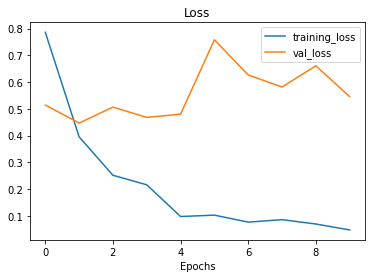

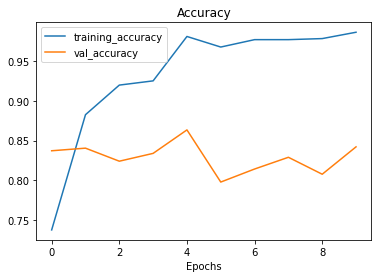

In [ ]:
plot_loss_curves(history_2)

## Model 3

Revert to the same model by loading weights from the checkpoint path

In [ ]:
model_1.load_weights(checkpoint_path)

In [ ]:
model_1.evaluate(validate_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.7048 - accuracy: 0.8156


[0.7047863006591797, 0.8155999779701233]

In [ ]:
# Check with layers are tunable in the whole model
for layer_number, layer in enumerate(model_1.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling2d True
4 output_layer True


In [ ]:
# Checking efficientnetb0 layer which layers could be train
for layer_number, layer in enumerate(model_1.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
fine_tune_epochs = initial_epochs + 5
history_3 = model_1.fit(train_data_10_percent,
                        epochs=10,
                        validation_data=validate_data,
                        validation_steps=int(0.25*len(validate_data)),
                        initial_epoch=history_1.epoch[-1],
                        callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                               experiment_name='10_percent_fine_tune')])